# PART 3: LSTM

**_TABLE OF CONTENT_**
     0. General Functions
     1. AAPL
        1.1 Train and test set size
        1.2 LSTM
     2. AMZN
     3. GOOG
     4. FB
     5. NFLX

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display

from keras.models import Sequential, Model
from keras.layers import Dense, RepeatVector, TimeDistributed, BatchNormalization, LeakyReLU, Input
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow.python.keras.utils.vis_utils import plot_model
from preprocessing import create_basetable
from datetime import date
from sklearn import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from helpFunctions import *
from sklearn.linear_model import LogisticRegression


In [2]:
start_independent = date(2020, 3, 22)
end_independent= date(2020, 11, 30)
start_dependent = date(2020, 12, 1)

In [3]:
def buildAE(trainX, testX):

    # Autoencoder model
        # define encoder
    n_inputs= trainX.shape[1]
    visible = Input(shape=(n_inputs,))

    # encoder level 1
    e = Dense(n_inputs*2)(visible)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)

    # encoder level 2
    e = Dense(n_inputs)(e)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)

    # bottleneck
    n_bottleneck = n_inputs/2
    bottleneck = Dense(n_bottleneck)(e)

    # define decoder, level 1
    d = Dense(n_inputs)(bottleneck)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)

    # decoder level 2
    d = Dense(n_inputs*2)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)
    # output layer
    output = Dense(n_inputs, activation='linear')(d)
    # define autoencoder model
    model = Model(inputs=visible, outputs=output)
    # compile autoencoder model
    model.compile(optimizer='adam', loss='mse')
    # plot the autoencoder
    plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)
    # fit the autoencoder model to reconstruct input
    history = model.fit(trainX, trainX, epochs=200, batch_size=32, verbose=0, validation_data=(testX,testX))
    # plot loss
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    # define an encoder model (without the decoder)
    encoder = Model(inputs=visible, outputs=bottleneck)
    plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)
    # save the encoder to file
    return encoder

In [4]:
def LRClassifier(encoder, x_train, x_test, y_train, y_test):
    # encode the train data
    X_train_encode = encoder.predict(x_train)
    # encode the test data
    X_test_encode = encoder.predict(x_test)
    # define the model
    model = LogisticRegression(random_state=123)
    # fit the model on the training set
    model.fit(X_train_encode, y_train)
    # make predictions on the test set
    pred = model.predict(X_test_encode)
    evaluate_model(pred, y_test)


In [5]:
def MLP_Classifier(encoder, x_train, x_test, y_train, y_test):
    # encode the train data
    X_train_encode = encoder.predict(x_train)
    # encode the test data
    X_test_encode = encoder.predict(x_test)
    # define the model
    model = MLPClassifier(random_state=123)
    # fit the model on the training set
    model.fit(X_train_encode, y_train)
    # make predictions on the test set
    pred = model.predict(X_test_encode)
    evaluate_model(pred, y_test)

In [6]:
def SVMClassifier(encoder, x_train, x_test, y_train, y_test):
    # encode the train data
    X_train_encode = encoder.predict(x_train)
    # encode the test data
    X_test_encode = encoder.predict(x_test)
    # define the model
    model = SVC(random_state= 123, verbose=1)
    # fit the model on the training set
    model.fit(X_train_encode, y_train)
    # make predictions on the test set
    pred = model.predict(X_test_encode)
    evaluate_model(pred, y_test)

## 1. AAPL

In [7]:
%%time
tck = 'AAPL'
# Retrieved scaled train and test set for specified stock symbol
x_train, x_test, y_train, y_test = create_basetable(tck,
                                                  start_independent= start_independent,
                                                  end_independent= end_independent,
                                                  start_dependent= start_dependent)

Wall time: 49.7 s


Inspect the size of the training and test set

In [8]:
buy_sell_observations(y_train, y_test)

--------Training set--------
Total number of observations:  152
Number of sell observations :  63
Number of buy observations :  89

--------Test set--------
Total number of observations:  71
Number of sell observations :  40
Number of buy observations :  31


AE model

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
AUC: 0.5205645161290323
              precision    recall  f1-score   support

           0       0.58      0.53      0.55        40
           1       0.46      0.52      0.48        31

    accuracy                           0.52        71
   macro avg       0.52      0.52      0.52        71
weighted avg       0.53      0.52      0.52        71



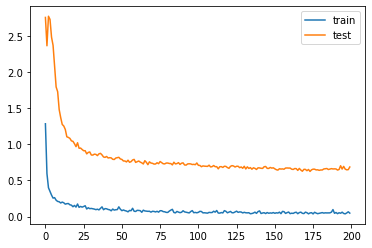

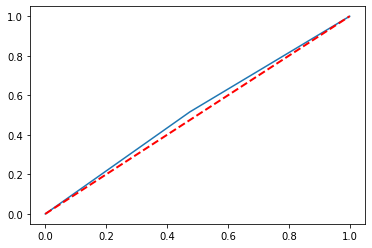

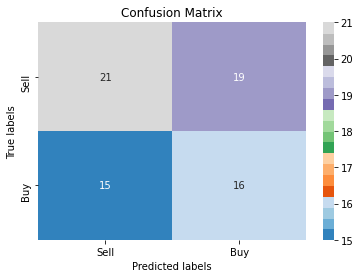

In [9]:
encoder = buildAE(x_train,x_test)
LRClassifier(encoder, x_train, x_test, y_train, y_test)

[LibSVM]AUC: 0.5245967741935484
              precision    recall  f1-score   support

           0       0.61      0.28      0.38        40
           1       0.45      0.77      0.57        31

    accuracy                           0.49        71
   macro avg       0.53      0.52      0.48        71
weighted avg       0.54      0.49      0.46        71



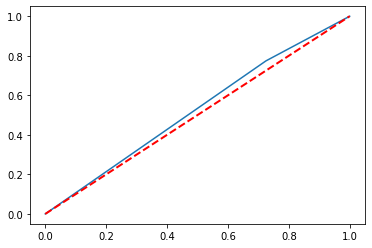

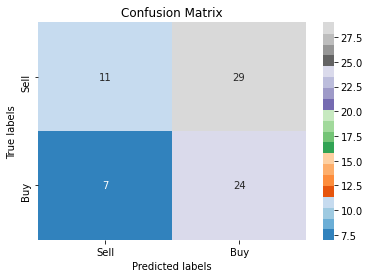

In [10]:
SVMClassifier(encoder, x_train, x_test, y_train, y_test)

c:\users\thijs vermeire\ideaprojects\masterthesis\venv2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC: 0.5278225806451613
              precision    recall  f1-score   support

           0       0.59      0.47      0.53        40
           1       0.46      0.58      0.51        31

    accuracy                           0.52        71
   macro avg       0.53      0.53      0.52        71
weighted avg       0.54      0.52      0.52        71



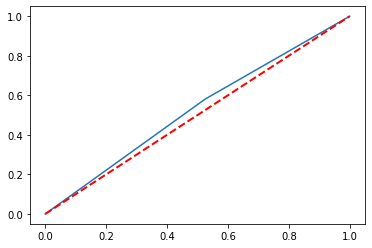

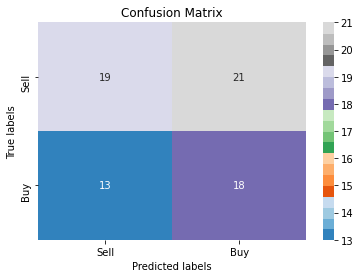

In [11]:
MLP_Classifier(encoder, x_train, x_test, y_train, y_test)

## 2. AMZN

In [12]:
%%time
tck = 'AMZN'
# Retrieved scaled train and test set for specified stock symbol
x_train, x_test, y_train, y_test = create_basetable(tck,
                                                  start_independent= start_independent,
                                                  end_independent= end_independent,
                                                  start_dependent= start_dependent)

Wall time: 46.9 s


Inspect the size of the training and test set

In [13]:
buy_sell_observations(y_train, y_test)

--------Training set--------
Total number of observations:  152
Number of sell observations :  61
Number of buy observations :  91

--------Test set--------
Total number of observations:  71
Number of sell observations :  36
Number of buy observations :  35


AE model

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
AUC: 0.5916666666666666
              precision    recall  f1-score   support

           0       0.60      0.58      0.59        36
           1       0.58      0.60      0.59        35

    accuracy                           0.59        71
   macro avg       0.59      0.59      0.59        71
weighted avg       0.59      0.59      0.59        71



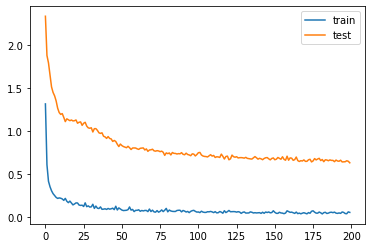

c:\users\thijs vermeire\ideaprojects\masterthesis\venv2\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


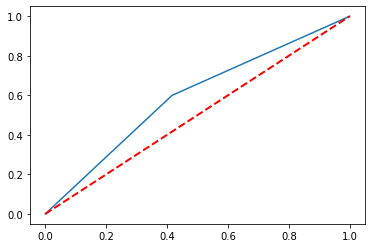

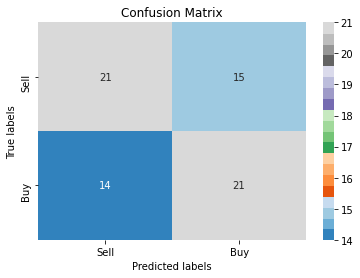

In [14]:
encoder = buildAE(x_train,x_test)
LRClassifier(encoder, x_train, x_test, y_train, y_test)

[LibSVM]AUC: 0.5138888888888888
              precision    recall  f1-score   support

           0       1.00      0.03      0.05        36
           1       0.50      1.00      0.67        35

    accuracy                           0.51        71
   macro avg       0.75      0.51      0.36        71
weighted avg       0.75      0.51      0.36        71



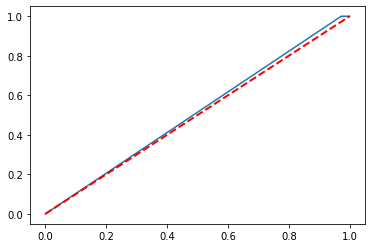

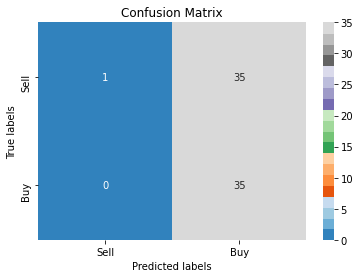

In [16]:
SVMClassifier(encoder, x_train, x_test, y_train, y_test)

AUC: 0.5075396825396825
              precision    recall  f1-score   support

           0       0.52      0.47      0.49        36
           1       0.50      0.54      0.52        35

    accuracy                           0.51        71
   macro avg       0.51      0.51      0.51        71
weighted avg       0.51      0.51      0.51        71



c:\users\thijs vermeire\ideaprojects\masterthesis\venv2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


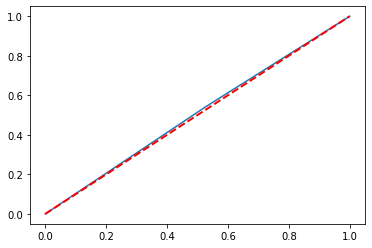

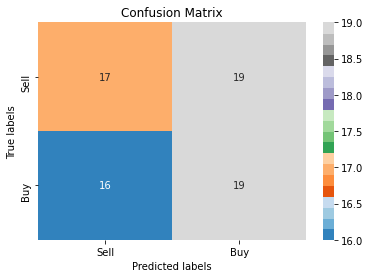

In [17]:
MLP_Classifier(encoder, x_train, x_test, y_train, y_test)

## 3. FB

In [18]:
%%time
tck = 'FB'
# Retrieved scaled train and test set for specified stock symbol
x_train, x_test, y_train, y_test = create_basetable(tck,
                                                  start_independent= start_independent,
                                                  end_independent= end_independent,
                                                  start_dependent= start_dependent)

Wall time: 47.7 s


Inspect the size of the training and test set

In [19]:
buy_sell_observations(y_train, y_test)

--------Training set--------
Total number of observations:  152
Number of sell observations :  63
Number of buy observations :  89

--------Test set--------
Total number of observations:  71
Number of sell observations :  36
Number of buy observations :  35


AE model

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
AUC: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.49      1.00      0.66        35

    accuracy                           0.49        71
   macro avg       0.25      0.50      0.33        71
weighted avg       0.24      0.49      0.33        71



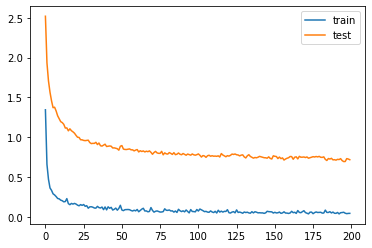

c:\users\thijs vermeire\ideaprojects\masterthesis\venv2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\thijs vermeire\ideaprojects\masterthesis\venv2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\thijs vermeire\ideaprojects\masterthesis\venv2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

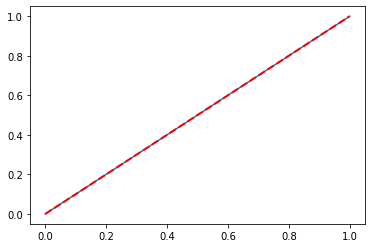

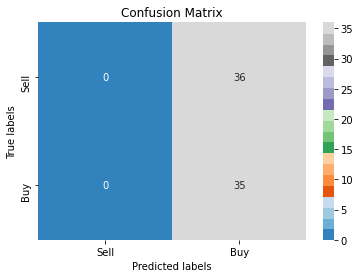

In [20]:
encoder = buildAE(x_train,x_test)
LRClassifier(encoder, x_train, x_test, y_train, y_test)

[LibSVM]AUC: 0.5666666666666667
              precision    recall  f1-score   support

           0       0.63      0.33      0.44        36
           1       0.54      0.80      0.64        35

    accuracy                           0.56        71
   macro avg       0.59      0.57      0.54        71
weighted avg       0.59      0.56      0.54        71



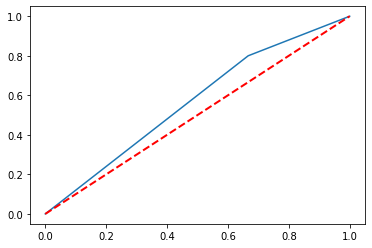

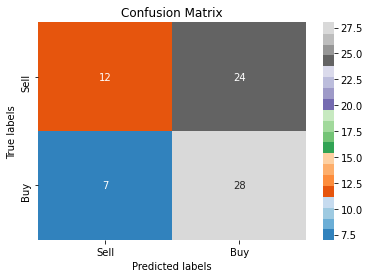

In [21]:
SVMClassifier(encoder, x_train, x_test, y_train, y_test)

c:\users\thijs vermeire\ideaprojects\masterthesis\venv2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC: 0.5416666666666667
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        36
           1       0.51      1.00      0.68        35

    accuracy                           0.54        71
   macro avg       0.76      0.54      0.42        71
weighted avg       0.76      0.54      0.41        71



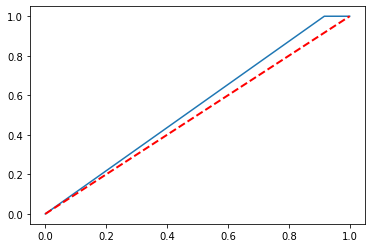

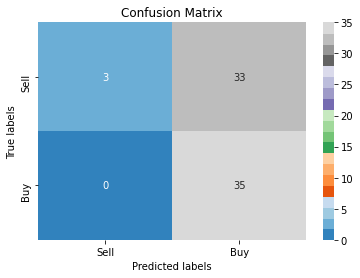

In [22]:
MLP_Classifier(encoder, x_train, x_test, y_train, y_test)

## 4. GOOG

In [23]:
%%time
tck = 'GOOG'
# Retrieved scaled train and test set for specified stock symbol
x_train, x_test, y_train, y_test = create_basetable(tck,
                                                  start_independent= start_independent,
                                                  end_independent= end_independent,
                                                  start_dependent= start_dependent)

Wall time: 45.5 s


Inspect the size of the training and test set

In [24]:
# Check the number of observations in the test and training set
buy_sell_observations(y_train, y_test)

--------Training set--------
Total number of observations:  152
Number of sell observations :  58
Number of buy observations :  94

--------Test set--------
Total number of observations:  71
Number of sell observations :  33
Number of buy observations :  38


AE model

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
AUC: 0.5159489633173844
              precision    recall  f1-score   support

           0       0.50      0.24      0.33        33
           1       0.55      0.79      0.65        38

    accuracy                           0.54        71
   macro avg       0.52      0.52      0.49        71
weighted avg       0.52      0.54      0.50        71



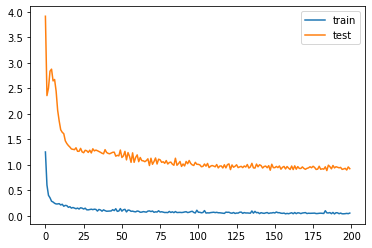

c:\users\thijs vermeire\ideaprojects\masterthesis\venv2\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


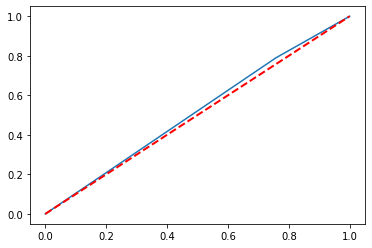

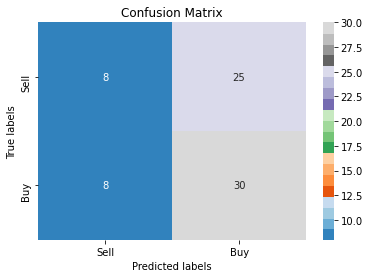

In [25]:
encoder = buildAE(x_train,x_test)
LRClassifier(encoder, x_train, x_test, y_train, y_test)

[LibSVM]AUC: 0.5303030303030303
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        33
           1       0.55      1.00      0.71        38

    accuracy                           0.56        71
   macro avg       0.78      0.53      0.41        71
weighted avg       0.76      0.56      0.43        71



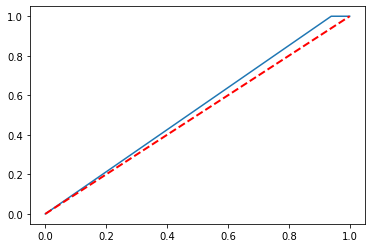

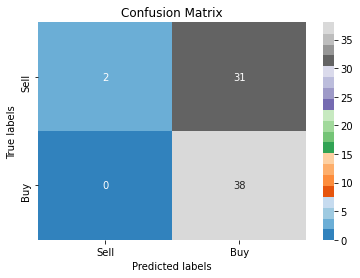

In [26]:
SVMClassifier(encoder, x_train, x_test, y_train, y_test)

AUC: 0.6088516746411483
              precision    recall  f1-score   support

           0       0.62      0.45      0.53        33
           1       0.62      0.76      0.68        38

    accuracy                           0.62        71
   macro avg       0.62      0.61      0.60        71
weighted avg       0.62      0.62      0.61        71



c:\users\thijs vermeire\ideaprojects\masterthesis\venv2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


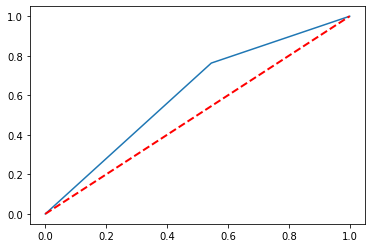

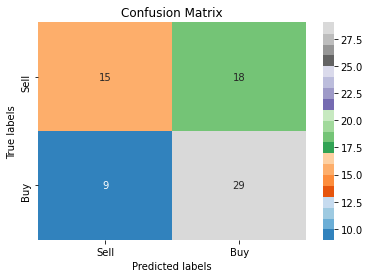

In [27]:
MLP_Classifier(encoder, x_train, x_test, y_train, y_test)

## 5. NFLX

In [28]:
%%time
tck = 'NFLX'
# Retrieved scaled train and test set for specified stock symbol
x_train, x_test, y_train, y_test = create_basetable(tck,
                                                  start_independent= start_independent,
                                                  end_independent= end_independent,
                                                  start_dependent= start_dependent)

Wall time: 54.6 s


Inspect the size of the training and test set

In [29]:
buy_sell_observations(y_train, y_test)

--------Training set--------
Total number of observations:  151
Number of sell observations :  69
Number of buy observations :  82

--------Test set--------
Total number of observations:  71
Number of sell observations :  37
Number of buy observations :  34


AE model

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
AUC: 0.5643879173290939
              precision    recall  f1-score   support

           0       0.59      0.54      0.56        37
           1       0.54      0.59      0.56        34

    accuracy                           0.56        71
   macro avg       0.56      0.56      0.56        71
weighted avg       0.57      0.56      0.56        71



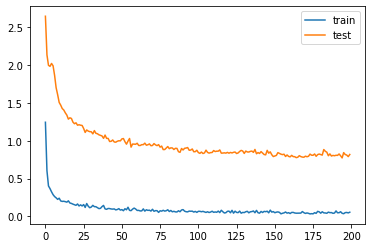

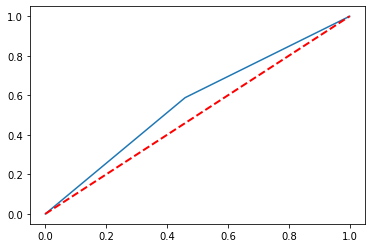

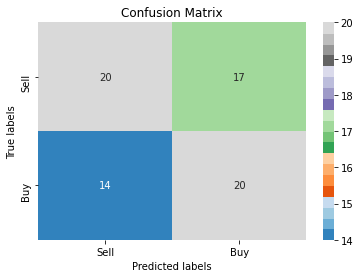

In [30]:
encoder = buildAE(x_train,x_test)
LRClassifier(encoder, x_train, x_test, y_train, y_test)

[LibSVM]AUC: 0.5782988871224165
              precision    recall  f1-score   support

           0       0.57      0.89      0.69        37
           1       0.69      0.26      0.38        34

    accuracy                           0.59        71
   macro avg       0.63      0.58      0.54        71
weighted avg       0.63      0.59      0.55        71



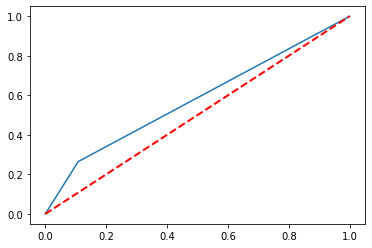

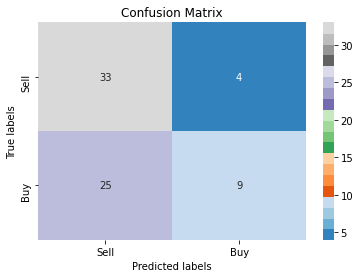

In [31]:
SVMClassifier(encoder, x_train, x_test, y_train, y_test)

c:\users\thijs vermeire\ideaprojects\masterthesis\venv2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC: 0.5926073131955485
              precision    recall  f1-score   support

           0       0.62      0.57      0.59        37
           1       0.57      0.62      0.59        34

    accuracy                           0.59        71
   macro avg       0.59      0.59      0.59        71
weighted avg       0.59      0.59      0.59        71



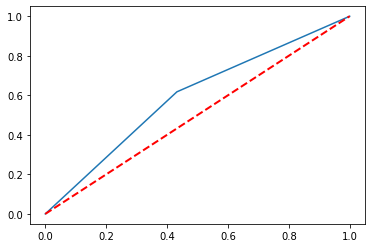

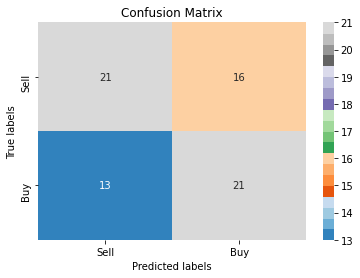

In [32]:
MLP_Classifier(encoder, x_train, x_test, y_train, y_test)